Багатошарова нейронна мережа для розв’язання задачі класифікації зображень із використанням TensorFlow.

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Prepare the data
num_classes = 100
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Configure the hyperparameters
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size
patch_size = 8  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2  # Size of the data array
embedding_dim = 256  # Number of hidden units
num_blocks = 4  # Number of blocks
print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

# Build a classification model
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

#Define an experiment
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history

#Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

#Implement patch extraction as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

#Implement the MLP-Mixer module
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

 #Build, train, and evaluate the MLP-Mixer model
        mlpmixer_blocks = keras.Sequential(
            [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
        )
        learning_rate = 0.005
        mlpmixer_classifier = build_classifier(mlpmixer_blocks)
        history = run_experiment(mlpmixer_classifier)       

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


Згорткова нейронна мережа для класифікації зображень із використанням  TensorFlow. 

169001437/169001437 [==============================] - 5s 0us/step
Epoch 1/100
800/800 [==============================] - 74s 89ms/step - loss: 4.1027 - accuracy: 0.0664 - val_loss: 3.7026 - val_accuracy: 0.1277
Epoch 2/100
800/800 [==============================] - 70s 88ms/step - loss: 3.4427 - accuracy: 0.1702 - val_loss: 3.2937 - val_accuracy: 0.1996
Epoch 3/100
800/800 [==============================] - 72s 90ms/step - loss: 3.0999 - accuracy: 0.2311 - val_loss: 3.0507 - val_accuracy: 0.2453
Epoch 4/100
800/800 [==============================] - 70s 88ms/step - loss: 2.8692 - accuracy: 0.2770 - val_loss: 2.9116 - val_accuracy: 0.2765
Epoch 5/100
800/800 [==============================] - 69s 86ms/step - loss: 2.6870 - accuracy: 0.3151 - val_loss: 2.7919 - val_accuracy: 0.2943
Epoch 6/100
800/800 [==============================] - 75s 93ms/step - loss: 2.5361 - accuracy: 0.3479 - val_loss: 2.7243 - val_accuracy: 0.3139
Epoch 7/100
800/800 [==============================] - 84s 106m

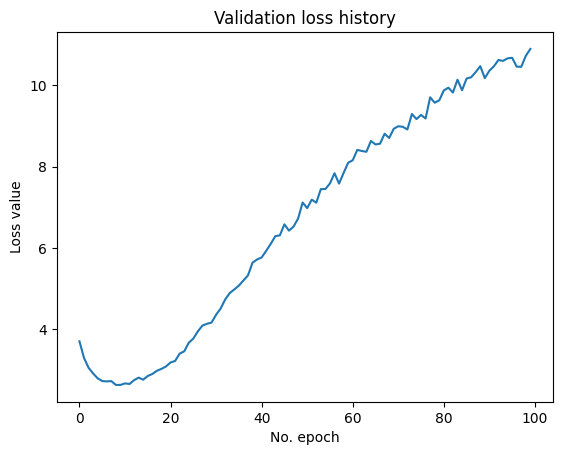

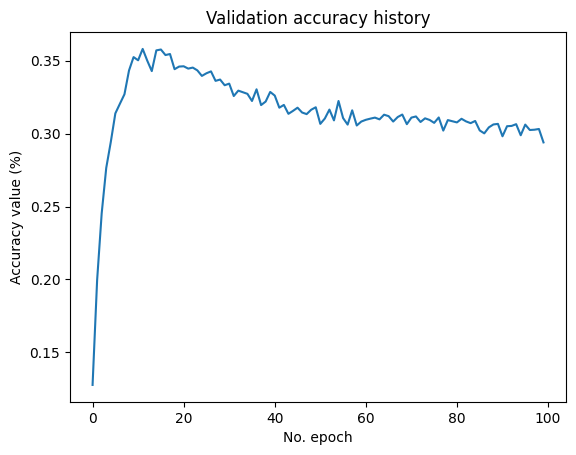

In [ ]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 100
optimizer = Adam()
validation_split = 0.2
verbosity = 1

# Load CIFAR-100 data
(input_train, target_train), (input_test, target_test) = cifar100.load_data()

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

# Create the model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

# Fit data to model
history = model.fit(input_train, target_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)

# Generate generalization metrics
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()